In [1]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, os, shutil, itertools, fnmatch, re
from scipy.interpolate import griddata, make_interp_spline, BSpline
import scipy.misc
import tensorflow as tf
import cirq
import seaborn as sns
import sys
import pickle as pkl
from PIL import Image, ImageDraw, ImageFont
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
code_path = "C:\\Users\\Andrew Patterson\\Google Drive\\PhD\\First Year\\Untitled Folder\\cirq_state_discrimination"
sys.path.append(code_path)
print(tf.__version__)
print(cirq.__version__)

2.0.0-beta1
0.6.0.dev


In [2]:
def create_args(path: str) -> str:
    args = ""
    with open(os.path.join(path, 'saved_params.json')) as f:
        params = json.load(f)

    if params['mu_a'] == 0.5:
        args = args + ' --file_loc=sigma005_mu05_bconst.json'
    elif params['mu_a'] == 0.25:
        args = args + ' --file_loc=sigma005_mu025_bconst.json'
    else:
        args = args + ' --max_epoch=25'
        data_args = ['prop_a', 'b_const', 'a_const', 'mu_a', 'mu_b', 'sigma_a', 'sigma_b']
        for a in data_args:
            args = args + ' --{}={}'.format(a, str(params[a]))
            
    dicts = (params['gate_dict'], params['gate_dict_0'], params['gate_dict_1'])
    dict_path = os.path.join(path, 'temp_dicts.pkl')
    with open(dict_path, 'wb') as f:
        pkl.dump(dicts, f, pkl.HIGHEST_PROTOCOL)
    
    args = args + " --dicts=\"{}\"".format(dict_path)

    other_args = ['cost_error', 'cost_incon', 'no_qubits', 'noise_on', 
                  'noise_prob', 'learning_rate', 'beta1', 'beta2']
    for a in other_args:
        args = args + ' --{}={}'.format(a, str(params[a]))
    return args
            
def generate_output_file(directory: str, use_tf: bool = False, mu_05: bool = True, old_dicts: bool = False) -> None:
    folder_list = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
#     folder_list = [f for f in os.listdir(directory) if f == '2019_07_30_13_40_05']
    for restore_path in folder_list:
        full_path = os.path.join(directory, restore_path)
        args = " --create_outputs" + " --restore_loc=\"{}\"".format(full_path)
        if use_tf:
            args = args + " --use_tf"
        args = args + create_args(full_path)
        
        run_file = os.path.join(code_path, 'run_training.py')
        os.system("python \"" + run_file +"\"" + args)
        
# generate_output_file(r"C:\Users\Andrew Patterson\Documents\PhD\cirq_state_discrimination\checkpoints\myriad_data\tf_noise_array_g", use_tf=True)

In [12]:
def label_plot(directory: str) -> None:
    folder_list = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    for path in folder_list:
        plot_path = os.path.join(directory, path, 'outputs')
        with open(os.path.join(directory, path, 'saved_params.json')) as f:
            param_dict = json.load(f)
        
        param_list = ['cost_error', 'cost_incon', 'noise_on', 'noise_prob', 'mu_a', 'sigma_a', 'job_name']
        if not param_dict['b_const']:
            param_list.extend(['mu_b', 'sigma_b'])
        
        msg = ""
        for i, param in enumerate(param_list):
            msg = msg + '{}: {} '.format(param, param_dict[param])
            if i % 3 == 0:
                msg = msg + "\n"
            
        font_path = os.path.join("C:\\Users\\Andrew Patterson\\Documents\\PhD\\fonts\\fonts\\ofl\\sourcecodepro", 'SourceCodePro-Light.ttf')
        font = ImageFont.truetype(font_path, size=10)
        plot = Image.open(os.path.join(plot_path, 'bar_graph.png'))
        
        width, height = plot.size
        cropped = plot.crop((100, 35, 570, 435))
        draw = ImageDraw.Draw(cropped)
        (x,y) = (5,5)
        colour = 'rgb(0, 0, 0)'
        draw.text((x,y), msg, fill=colour, font=font)
        save_path = os.path.join(plot_path, 'plot_labeled.png')
        cropped.save(save_path)
        os.system("convert \"{}\" -fuzz 2% -transparent white \"{}\"".format(save_path, save_path))
        
# label_plot(r"C:\Users\Andrew Patterson\Documents\PhD\cirq_state_discrimination\checkpoints\myriad_data\tf_noise_off_g")

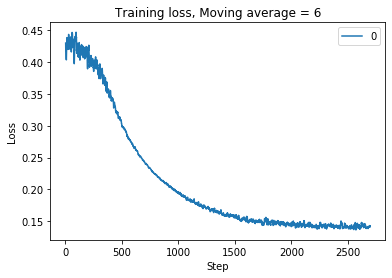

<Figure size 432x288 with 0 Axes>

In [11]:
def nwise(iterable, n):
    ts = itertools.tee(iterable, n)
    for c, t in enumerate(ts):
        next(itertools.islice(t, c, c), None)
    return zip(*ts)

def moving_average(iterable, n):
    yield from (sum(x)/n for x in nwise(iterable, n))
    
def plot_loss_fn(folder, n=6, no_noise=None, cutoff=7500):
    """
    Input: Takes a list of folders where models are strored and returns a graph of convergences plotted together 
    """
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Step')
    ax.set_ylabel('Loss')
    ax.set_title('Training loss, Moving average = {}'.format(n))
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    event_file = fnmatch.filter(files, 'events*')
    steps = []
    loss = []
    for e in tf.compat.v1.train.summary_iterator(os.path.join(folder, event_file[0])):
        for v in e.summary.value:
            if v.tag == 'Training loss':
                if e.step <= cutoff:
                    steps.append(e.step)
                    val = np.frombuffer(v.tensor.tensor_content, dtype=np.float32)[0]
                    loss.append(val)

    param_file = os.path.join(folder, 'saved_params.json')
    with open(param_file, 'r') as f:
        params = json.load(f)
    if params['noise_on'] == "False":
        noise_level = 0
    else:
        noise_level = params['noise_prob']
    tot_cost = float(params['cost_error']) + float(params['cost_incon'])
    loss = np.array(loss)
    loss = loss / tot_cost
    np.save((step, loss), os.path.join(folder, 'outputs', 'loss_fn.npy'))
    loss_ma = moving_average(loss, n)
    step_ma = moving_average(steps, n)
    ax.plot(list(step_ma), list(loss_ma), label=noise_level)
    ax.legend()
    plt.savefig(os.path.join(folder, 'outputs', 'loss_fn.png'))
    plt.show()

def save_loss_fns(directory: str):
    folder_list = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    for path in folder_list:
        plot_loss_fn(os.path.join(directory, path))
save_loss_fns(r"C:\Users\Andrew Patterson\Documents\PhD\cirq_state_discrimination\checkpoints\myriad_data\tf_noise_off_g")

In [21]:
def create_data_frame(directory: str):
    df = pd.DataFrame()
    folder_list = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    for f in folder_list:
        path = os.path.join(directory, f)
        probs_path = os.path.join(path, 'outputs', 'probs.npy')
        if os.path.isfile(probs_path):
            with open(os.path.join(path, 'saved_params.json')) as js:
                params = json.load(js)
            probs = np.load(probs_path)

            p_error = np.average([probs[0][1], probs[1][0]])
            p_inc = np.average([probs[0][2], probs[1][2]])
            p_suc = np.average([probs[0][0], probs[1][1]])

            loss = p_error + p_inc

            df = df.append({'P_err': p_error, 'P_inc': p_inc, 'P_suc': p_suc, 'cost_err': params['cost_error'],
                            'cost_inc': params['cost_incon'], 'noise_on': params['noise_on'],
                            'noise_prob': params['noise_prob'], 'learning_rate': params['learning_rate'],
                            'loss': loss, 'folder': str(f)},
                           ignore_index=True)


    numeric = ['cost_err', 'cost_inc', 'noise_prob', 'learning_rate']
    df[numeric] = df[numeric].apply(pd.to_numeric, errors='coerce', axis=1)
    if not os.path.exists(os.path.join(directory, 'output')):
        os.mkdir(os.path.join(directory, 'output'))
    df.to_pickle('dataframe.pkl')
    return df

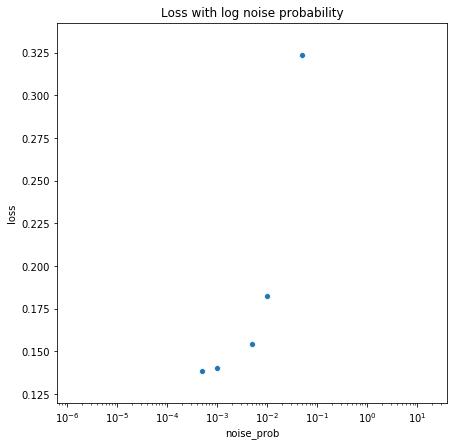

In [27]:
df = create_data_frame(r"C:\Users\Andrew Patterson\Documents\PhD\cirq_state_discrimination\checkpoints\myriad_data\tf_noise_array_g")
f, ax = plt.subplots(figsize=(7,7))
ax.set(xscale='log', title='Loss with log noise probability')
sns.scatterplot(df['noise_prob'], df['loss'], ax=ax)

In [ ]:
def pre_trained_new_noise_level(restore_directory: str, use_tf: bool, noise_levels: list):
    noise_levels_path = os.path.join(restore_directory, 'outputs_with_noise_levels')
    if not os.path.exists(noise_levels_path):
        os.mkdir(noise_levels_path)
        
    for noise in noise_levels:
        args = " --create_outputs" + " --restore_loc=\"{}\"".format(restore_directory)    
        if use_tf:
            args = args + " --use_tf"
        args = args + create_args(restore_directory)
        re.sub('(--noise_prob=\d*.\d*)', "--noise_prob={}".format(noise), args)
        
        noise_dir = os.path.join(noise_levels_path, re.sub('\.', '_', str(noise)))
        args = args + ' --output_loc=\"{}\"'.format(noise_dir)
        run_file = os.path.join(code_path, 'run_training.py')
        os.system("python \"" + run_file +"\"" + args)
        
def pre_trained_multiple(directory: str, use_tf: bool, noise_levels: list):
    folder_list = [f for f in os.listdir(directory) if os.path.isdir(os.path.join(directory, f))]
    for path in folder_list:
        pre_trained_new_noise_level(os.path.join(directory, path), use_tf, noise_levels)
noise_levels = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25]        
pre_trained_multiple(r"C:\Users\Andrew Patterson\Documents\PhD\cirq_state_discrimination\checkpoints\myriad_data\tf_noise_off_g", True, noise_levels)